# Context

##  Final Run:

- In this notebook, we perform a final evaluation run.
- We have added a test set to evaluate the aggregation of all the different models.
- The code structure is the same as in the previous notebooks, which were organized by phylum. However, for each phylum, the selected model and hyperparameters may differ slightly.
- For the **Echinodermata** phylum, no model was built, as it contained only a single family. Therefore, knowing the phylum directly reveals the family classification of the image.


# Imports

In [2]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [7]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Rescaling, RandAugment
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

In [6]:


# With colab
folder_path = '/content/rare_species 1'
meta = pd.read_csv('/content/rare_species 1/metadata.csv')


# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

# Test Set Creation and Data Splitting Strategy

In order to properly test if our overall model behave as expected, we needed to create a specific test set that does not follow the classic Keras approach. The process is as follows:

- Use `train_test_split` from **scikit-learn** to create a separate test set.
- Use a custom cell to reorganize the remaining train and validation data into folders for each phylum, allowing us to leverage Keras' `train_val_split`.
- Create a separate split for each phylum to train models specifically designed for them.  
  (You can see the detailed process for each phylum in the corresponding notebooks named `best_model_PhylumName`.)
- The idea is again to aggregate those model together using a function


In [10]:
meta_train_val , meta_test = train_test_split(meta, test_size=0.1, random_state=42, stratify =meta['family'])

In [12]:
# With colab
current_locations = '/content/rare_species 1'

# with vscode
# current_locations = '../data/rare_species 1'

for _, row in meta_train_val.iterrows():

    phylum = row['phylum']
    file_path = row['file_path']


    file_location = os.path.join(current_locations, file_path)

    # create a a detination folder keeping the subfolder structure

        # with colab
    target_folder = os.path.join(phylum, os.path.dirname(file_path))

        # with vscode
    # target_folder = os.path.join("../data" , phylum, os.path.dirname(file_path))

    os.makedirs(target_folder, exist_ok=True)  # Make sure the folder exists

    # Final destination path
    destination = os.path.join(target_folder, os.path.basename(file_path))

    # Copy the file if it exists
    if os.path.exists(file_location):
        shutil.copy2(file_location, destination)
    else:
        print(f"Couldn't find the file: {file_location}")

## Final Train, Val, Test, Split

In [60]:
# with colab
path_phylum_athropoda = "/content/arthropoda"
path_phylum_chordata = "/content/chordata"
path_phylum_cnidaria = "/content/cnidaria"
path_phylum_mollusca = "/content/mollusca"

# with vscode
# path_phylum_athropoda = "../data/arthropoda"
# path_phylum_chordata = "../data/chordata"
# path_phylum_cnidaria = "../data/cnidaria"
# path_phylum_mollusca = "../data/mollusca"

image_size = (224, 224)
seed = 42
batch_size = 32

train_ds_arthropoda, val_arthropoda= keras.utils.image_dataset_from_directory(
    path_phylum_athropoda,
    validation_split=0.2,
    subset= "both",
    seed= seed,
    image_size= image_size,
    batch_size= batch_size
)

train_ds_chordata, val_chordata= keras.utils.image_dataset_from_directory(
    path_phylum_chordata,
    validation_split=0.2,
    subset= "both",
    seed= seed,
    image_size= image_size,
    batch_size= batch_size
)

train_ds_cnidaria, val_cnidaria= keras.utils.image_dataset_from_directory(
    path_phylum_cnidaria,
    validation_split=0.2,
    subset= "both",
    seed= seed,
    image_size= image_size,
    batch_size= batch_size
)

train_ds_mollusca, val_mollusca= keras.utils.image_dataset_from_directory(
    path_phylum_mollusca,
    validation_split=0.2,
    subset= "both",
    seed= seed,
    image_size= image_size,
    batch_size= batch_size
)



Found 856 files belonging to 17 classes.
Using 685 files for training.
Using 171 files for validation.
Found 8956 files belonging to 166 classes.
Using 7165 files for training.
Using 1791 files for validation.
Found 729 files belonging to 13 classes.
Using 584 files for training.
Using 145 files for validation.
Found 189 files belonging to 5 classes.
Using 152 files for training.
Using 37 files for validation.


In [61]:
def display_images(train_ds):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(8, 8))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
        plt.tight_layout()
        plt.show()

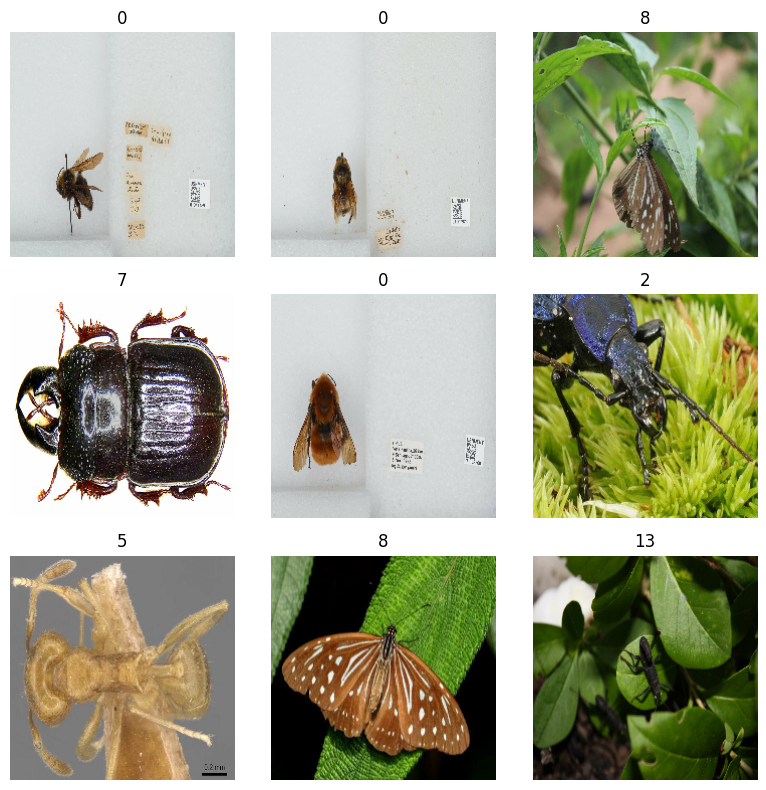

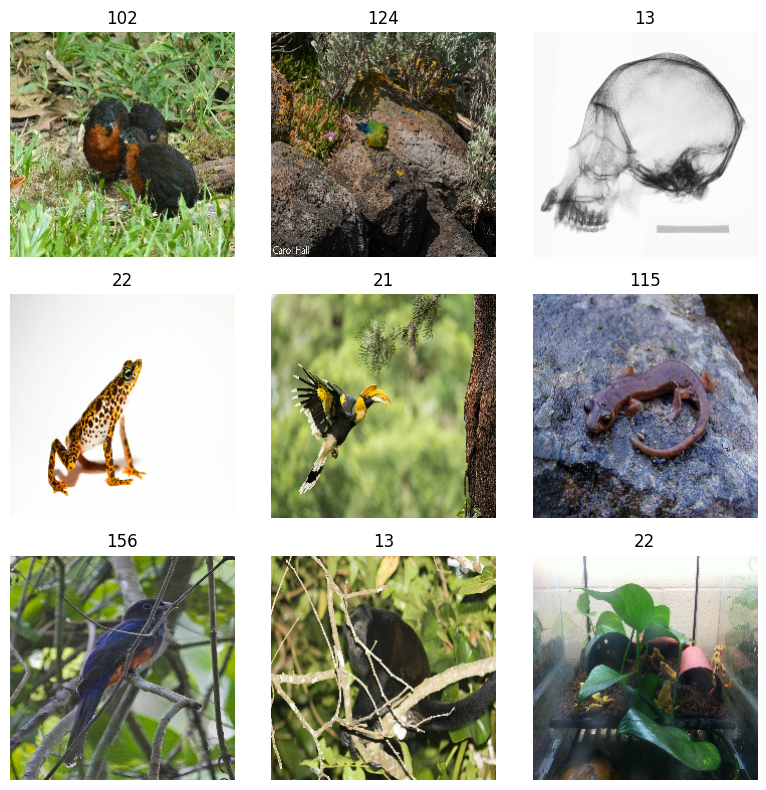

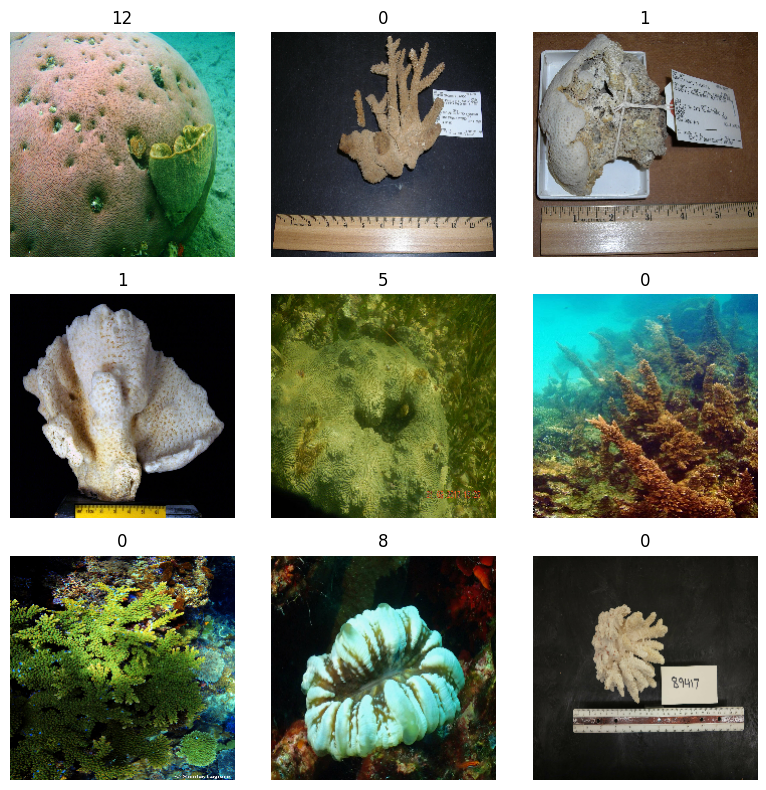

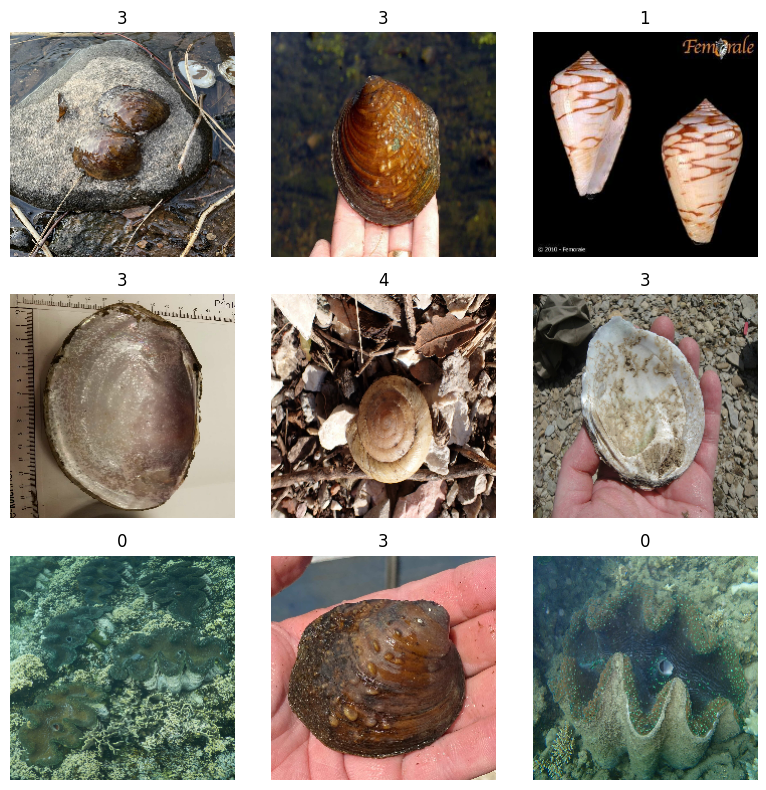

In [15]:
display_images(train_ds_athropoda)
display_images(train_ds_chordata)
display_images(train_ds_cnidaria)
display_images(train_ds_mollusca)

# Data Augmentation

In this section we use the augmentation layers that were build individually for every Phylum type

In [51]:
data_augmentation_arthropoda = keras.Sequential([
    layers.RandAugment(value_range=(0, 255))
])

data_augmentation_chordata= keras.Sequential([

    # apply any kind of kera preprocessing randomly
    layers.RandAugment(value_range=(0, 255), num_ops=2),

    # change the image by moving or zooming in
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2), # 20 percent rotation
    layers.RandomZoom(0.2), # 20 percent rotation


    # change the image rgbs --> contrast and brightness
    layers.RandomContrast(0.2, value_range=(0, 255)), # change by 20%
    layers.RandomBrightness(0.2, (0, 255)), # cahnge by 20 %

    # adds noise to the images to prevent overfitting (blurry filter)
    layers.GaussianNoise(0.1),

])

data_augmentation_cnidaria= [

 ## add any you want here
]

data_augmentation_mollusca = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),   # Rotate images randomly up to 20%
    layers.RandomZoom(0.2),        # Zoom in/out randomly up to 20%
    layers.RandomContrast(0.2)     # Change contrast randomly up to 20%
])


data_augmentation_arthropoda = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),   # Rotate images randomly up to 20%
    layers.RandomZoom(0.2),        # Zoom in/out randomly up to 20%
    layers.RandomContrast(0.2)     # Change contrast randomly up to 20%
])


# Models

(for more specificity over the different models you can refferes to the different notebook `best_model_PhylumName`. )

## Build the models

Arthropoda


In [56]:
def make_model_athropoda(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation_arthropoda(inputs)
    x = Rescaling(1./255)(x)

    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)  # Optional regularization

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


chordata


In [45]:
def make_model_chordata(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Rescaling layer
    x = data_augmentation_chordata(inputs)
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False  # Freeze for transfer learning

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x) # to avoid over fitting
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.001))(x) #try to prevent overfitting

    model = keras.Model(inputs, outputs)
    model.base_model = base_model # save thee base model to be able to call it back when fine tunning

    return model

cnidaria


In [22]:
def make_model_cnidaria(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    return keras.Model(inputs, outputs)

mollusca

In [41]:
def make_model_mollusca(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Apply data augmentation
    x = data_augmentation_mollusca(inputs)  #

    # Normalize pixel values
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base (frozen)
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False # Freeze for transfer learning

    # Flatten instead of pooling (as required)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)               # GlobalAveragePooling2D or Flatten
    x = layers.Dropout(0.3)(x)      # Optional regularization, change, it randomly sets eurons to 0 to reduce overfitting. so 0.1 is 10% of neurons are of.

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

## Run The models and Evaluation

In [54]:
def evaluate_model_predictions(model_path, test_ds):

    model = keras.models.load_model(model_path)
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.concatenate([y for _, y in test_ds], axis=0)

    print(classification_report(y_true, y_pred))

### Chordata

#### First run

In [66]:
model_chordata = make_model_chordata(input_shape=image_size + (3,), num_classes=166)
epochs = 10

callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_chordata.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model_chordata.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_chordata.fit(
    train_ds_chordata,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_chordata,
)

<ipython-input-45-a221d708fec0>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.1080 - loss: 5.1407
Epoch 1: val_acc improved from -inf to 0.36795, saving model to best_model_chordata.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 720s 3s/step - acc: 0.1083 - loss: 5.1373 - val_acc: 0.3680 - val_loss: 2.9910
Epoch 2/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.3685 - loss: 2.9803
Epoch 2: val_acc improved from 0.36795 to 0.42993, saving model to best_model_chordata.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 721s 3s/step - acc: 0.3686 - loss: 2.9800 - val_acc: 0.4299 - val_loss: 2.7135
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.4455 - loss: 2.5752
Epoch 3: val_acc improved from 0.42993 to 0.44668, saving model to best_model_chordata.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 786s 3s/step - acc: 0.4455 - loss: 2.5751 - val_acc: 0.4467 - val_loss: 2.6049
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.5006 - loss: 2.3263
Epoch 4: val_acc improved from 0.44668 to 0.46008, saving model to best_model_ch

#### Fine tunning

In [67]:
fine_tune_epochs = 20

# we recall the model only this time we allow it to change the layers in the base model
# we load the weights of the best reuslt of the first training
fine_tune_model = make_model_chordata(input_shape=image_size + (3,), num_classes=166)
fine_tune_model.load_weights("best_model_chordata.keras")

# only unfreeze the lasts layer of the pretrained model here 20
fine_tune_model.base_model.trainable = True
for layer in fine_tune_model.base_model.layers[:-40]:
    layer.trainable = False


fine_tune_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), # lower learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

fine_tune_model.fit(
    train_ds_chordata,
    epochs=fine_tune_epochs,
    validation_data=val_chordata,
    callbacks=callbacks
)

<ipython-input-45-a221d708fec0>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.4756 - loss: 2.4158
Epoch 1: val_acc did not improve from 0.47571
224/224 ━━━━━━━━━━━━━━━━━━━━ 811s 4s/step - acc: 0.4758 - loss: 2.4151 - val_acc: 0.4668 - val_loss: 2.7444
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.5796 - loss: 1.9340
Epoch 2: val_acc improved from 0.47571 to 0.48800, saving model to best_model_chordata.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 812s 4s/step - acc: 0.5797 - loss: 1.9336 - val_acc: 0.4880 - val_loss: 2.6405
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.6481 - loss: 1.6610
Epoch 3: val_acc improved from 0.48800 to 0.50698, saving model to best_model_chordata.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 850s 4s/step - acc: 0.6481 - loss: 1.6610 - val_acc: 0.5070 - val_loss: 2.5271
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.6652 - loss: 1.5522
Epoch 4: val_acc improved from 0.50698 to 0.51200, saving model to best_model_chordata.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 80

KeyboardInterrupt: 

In [68]:
drive_model_path = '/content/drive/MyDrive/models/best_model_chordata.keras'

#create folder in google drive if you dont have ome alraedy there
os.makedirs(os.path.dirname(drive_model_path), exist_ok=True)

best_model = keras.models.load_model("best_model_chordata.keras")
best_model.save(drive_model_path)


### Cnidaria

In [ ]:
drive_model_path = '/content/drive/MyDrive/models/best_model_cnidaria.keras'

best_model = keras.models.load_model("best_model_cnidaria.keras")
best_model.save(drive_model_path)

### Mollusca

In [33]:
class_names = train_ds_mollusca.class_names
print("Mollusca families (classes):", class_names)

Mollusca families (classes): ['mollusca_cardiidae', 'mollusca_conidae', 'mollusca_haliotidae', 'mollusca_unionidae', 'mollusca_zonitidae']


In [ ]:
model_mollusca = make_model_mollusca(input_shape=image_size + (3,), num_classes=len(train_ds_mollusca.class_names))
epochs = 20

# Callback to save the best model based on validation accuracy
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_mollusca.keras",  # Updated file name
        save_best_only=True,
        monitor="val_acc",            # Metric matches the one in compile
        mode="max",
        verbose=1
    )
]

# Compile the model
model_mollusca.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

# Train the model
history = model_mollusca.fit(
    train_ds_mollusca,
    validation_data=val_mollusca,
    epochs=epochs,
    callbacks=callbacks
)

In [ ]:
drive_model_path = '/content/drive/MyDrive/models/best_model_mollusca.keras'

best_model = keras.models.load_model("best_model_mollusca.keras")
best_model.save(drive_model_path)

### Arthropoda

In [69]:
model_arthropoda = make_model_mollusca(input_shape=image_size + (3,), num_classes=len(train_ds_arthropoda.class_names))
epochs = 20


callbacks = [
    # saves the best model of the run using max val_accuracy as a metric
    keras.callbacks.ModelCheckpoint(
        "best_model_arthropoda.keras",
        save_best_only=True,
        monitor="val_acc",
        mode="max",
        verbose=1)
    ]

## change from kera example is the loss function as we deal with a lot of classes
model_arthropoda.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), ## change this CategoricalCrossentropy to the the one it is now
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")], ## change this CategoricalCrossentropy to the the one it is now
)

model_arthropoda.fit(
    train_ds_arthropoda,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_arthropoda,
)



<ipython-input-41-945c9d4cde2e>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


Epoch 1/20
 4/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.0449 - loss: 3.3848

KeyboardInterrupt: 

In [ ]:
drive_model_path = '/content/drive/MyDrive/models/best_model_arthropoda.keras'

best_model = keras.models.load_model("best_model_chordata.keras")
best_model.save(drive_model_path)

# Evaluation